# Machine Learning in Network Science
Group Challenge

***
by: Leonardo Basili, Paul Bédier, Lasse Schmidt

within: MS Data Sciences & Business Analytics

at: CentraleSupélec & ESSEC Business School
***

This notebook covers classical machine learning techniques, namely:
- unsupervised link prediction based on graph-topology (Adamic Adar, Preferential Attachment, Resource-Allocation-Index, ...)
- supervised link prediction using Logistic Regression, SVM, Random Forest & Boosting

### 1. Import Packages

In [3]:
from importlib import reload
reload(analyseData)
reload(prepData)
reload(loadData)
reload(modeling)
reload(autoenc)

<module 'util.autoencoder' from 'c:\\Users\\pbedi\\Documents\\GitHub\\Network-Science_Challenge\\util\\autoencoder.py'>

In [1]:
# import own scripts
import util.analyse_Data as analyseData
import util.preprocess_Data as prepData
import util.load_Data as loadData
import util.modeling as modeling
import util.autoencoder as autoenc

c:\Users\pbedi\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# parse & handle data
import os
import csv
import numpy as np
import pandas as pd
import networkx as nx # graph data

# modeling
import torch
from torch_geometric.nn import GAE, VGAE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier

# hyperparameter tuning
from ray import tune, air
from ray.tune import CLIReporter, JupyterNotebookReporter
from ray.tune.search.hyperopt import HyperOptSearch
from ray.tune.schedulers import ASHAScheduler, MedianStoppingRule, PopulationBasedTraining
from ray.tune.stopper import MaximumIterationStopper
from ray.tune.experiment.trial import Trial
from ray.tune.sklearn import TuneSearchCV

# evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.model_selection import PredefinedSplit, ShuffleSplit

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# set matplotlib and seaborn settings for nicer plots
%matplotlib inline

SMALL_SIZE = 6
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)   # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### 2. Load Data for Modeling

In [4]:
# might take up to a minute
(G, G_train, node_info,
 train_tf, val_tf, trainval_tf,
 test, test_tf,
 X_train, y_train, X_val, y_val, X_trainval, y_trainval,
 X_test) = loadData.load_transform(testing_ratio = 0.2, n2v_train=True)

Number of positive edges for training: 4174
Number of positive edges for validation: 1043
Number of edges in original graph: 5217
Number of edges in training graph: 4174
The graph is connected


Generating walks (CPU: 1): 100%|██████████| 10/10 [00:16<00:00,  1.66s/it]


Enriching train data...


c:\Users\pbedi\Documents\GitHub\Network-Science_Challenge\util\preprocess_Data.py:130: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G, nodelist = nodelist)
c:\Users\pbedi\Documents\GitHub\Network-Science_Challenge\util\preprocess_Data.py:99: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G, nodelist = nodelist)
c:\Users\pbedi\Documents\GitHub\Network-Science_Challenge\util\preprocess_Data.py:153: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G, nodelist = nodelist).toarray()
c:\Users\pbedi\Documents\GitHub\Network-Science_Challenge\util\preprocess_Data.py:153: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G, nodelist = nodelist).toarray()
c:\Users\pbedi\Do

Enriching validation data...


c:\Users\pbedi\Documents\GitHub\Network-Science_Challenge\util\preprocess_Data.py:130: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G, nodelist = nodelist)
c:\Users\pbedi\Documents\GitHub\Network-Science_Challenge\util\preprocess_Data.py:99: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G, nodelist = nodelist)
c:\Users\pbedi\Documents\GitHub\Network-Science_Challenge\util\preprocess_Data.py:153: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G, nodelist = nodelist).toarray()
c:\Users\pbedi\Documents\GitHub\Network-Science_Challenge\util\preprocess_Data.py:153: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G, nodelist = nodelist).toarray()
c:\Users\pbedi\Do

Enriching test data...


c:\Users\pbedi\Documents\GitHub\Network-Science_Challenge\util\preprocess_Data.py:130: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G, nodelist = nodelist)
c:\Users\pbedi\Documents\GitHub\Network-Science_Challenge\util\preprocess_Data.py:99: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G, nodelist = nodelist)
c:\Users\pbedi\Documents\GitHub\Network-Science_Challenge\util\preprocess_Data.py:153: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G, nodelist = nodelist).toarray()
c:\Users\pbedi\Documents\GitHub\Network-Science_Challenge\util\preprocess_Data.py:153: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G, nodelist = nodelist).toarray()
c:\Users\pbedi\Do

In [10]:
# might take up to a minute
data, _ = autoenc.load(testing_ratio = 0.2)

Number of positive edges for training: 4174
Number of positive edges for validation: 1043
Number of edges in original graph: 5217
Number of edges in training graph: 4174
The graph is connected
Enriching node features...


Generating walks (CPU: 1): 100%|██████████| 10/10 [00:15<00:00,  1.53s/it]
c:\Users\pbedi\AppData\Local\Programs\Python\Python39\lib\site-packages\networkx\algorithms\link_analysis\hits_alg.py:78: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G, nodelist=list(G), dtype=float)
Generating walks (CPU: 1): 100%|██████████| 10/10 [00:16<00:00,  1.70s/it]
c:\Users\pbedi\AppData\Local\Programs\Python\Python39\lib\site-packages\networkx\algorithms\link_analysis\hits_alg.py:78: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G, nodelist=list(G), dtype=float)


Create PyTorch Geometric dataset...


In [11]:
# get node embeddings (IF YOU CHANGE SEED = 42, then you need to train new autoencoder as train-val split is different)

# load best autoencoder
path = os.path.abspath("")+"\\models\\autoencoder.pt"
model = VGAE(autoenc.Encoder(data.x.size()[1], 64, 1.5, 5, 0.2, 0.01))
model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))

# get embeddings of nodes
embedding = autoenc.get_embeddings(model, data.x, data.trainval_edges)
node_emb = pd.DataFrame(embedding).rename(columns = {val: f"x{val+1}" for val in range(embedding.shape[1])})

# enrich train
train_sim = pd.DataFrame(autoenc.get_similarity(model, data.x, data.train_pos_edges, data.train_edges)).rename(columns = {0: "sim"})
train_tf = (train_tf
    .assign(sim = train_sim.sim.values)
    .assign(dist = lambda df_: [np.linalg.norm(node_emb.loc[u].values-node_emb.loc[v].values) for u, v in zip(df_.node1, df_.node2)])
)

# enrich val
val_sim = pd.DataFrame(autoenc.get_similarity(model, data.x, data.train_pos_edges, data.val_edges)).rename(columns = {0: "sim"})
val_tf = (val_tf
    .assign(sim = val_sim.sim.values)
    .assign(dist = lambda df_: [np.linalg.norm(node_emb.loc[u].values-node_emb.loc[v].values) for u, v in zip(df_.node1, df_.node2)])
)

# enrich test
test_sim = pd.DataFrame(autoenc.get_similarity(model, data.x, data.trainval_pos_edges, data.test_edges)).rename(columns = {0: "sim"})
test_tf = (test_tf
    .assign(sim = test_sim.sim.values)
    .assign(dist = lambda df_: [np.linalg.norm(node_emb.loc[u].values-node_emb.loc[v].values) for u, v in zip(df_.node1, df_.node2)])
)

# split
X_train, y_train = loadData.split_frame(train_tf)
X_val, y_val     = loadData.split_frame(val_tf)
X_test           = loadData.split_frame(test_tf)

# merge to get trainval data
X_trainval = pd.concat([X_train, X_val])
y_trainval = pd.concat([y_train, y_val])

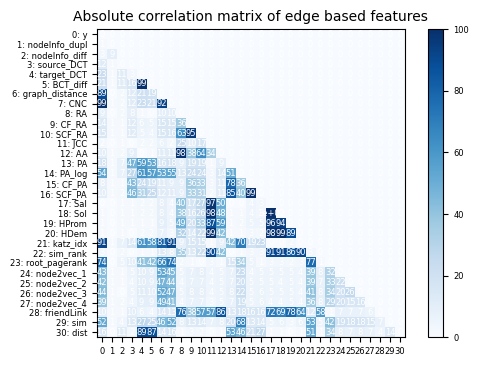

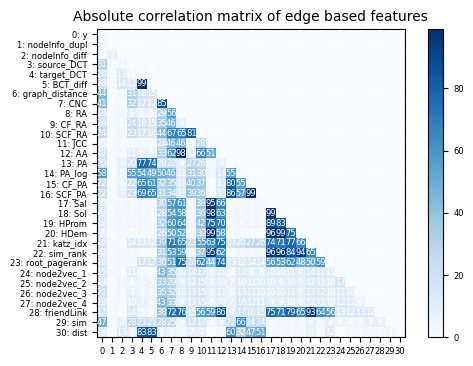

In [12]:
# plot correlation with target (first train, then validation)
for df in [train_tf, val_tf]:
    analyseData.plot_corr_matrix(df.iloc[:, 2:])

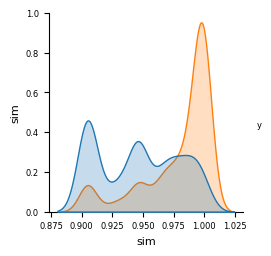

In [13]:
sns.pairplot(val_tf[["sim", "y"]], hue = "y")

### 3. Supervised Link Prediction

In [54]:
# prepare datasets for supervised methods, removing features highly correlated with target in train set but not in val set
cols = ['JCC', 'AA', 'PA_log', 'SoI', 'HProm', 'root_pagerank']
X_trainval_sv  =  X_trainval[[col for col in X_trainval.columns  if col in cols]]
X_train_sv  =  X_train[[col for col in X_train.columns  if col in cols]]
X_val_sv  =  X_val[[col for col in X_val.columns  if col in cols]]
X_test_sv  =  X_test[[col for col in X_test.columns  if col in cols]]

# preparing predifined cv split for sklearn
val_fold = [0 if i in X_val_sv.index else -1 for i in X_trainval_sv.index]
ps = PredefinedSplit(val_fold)
ps.get_n_splits()

1

##### a) Logistic Regression

In [55]:
# logistic regression
clf = LogisticRegressionCV(max_iter = 10000, cv = ps)
clf.fit(X_trainval_sv, y_trainval)

# predict val
y_trainval_hat = clf.predict(X_trainval_sv)
# compute accuracy
acc_trainval = accuracy_score(y_trainval, y_trainval_hat)

# predict val
y_val_hat = clf.predict(X_val_sv)
# compute accuracy
acc_val = accuracy_score(y_val, y_val_hat)

# print performance
print(f"Acc train: {acc_trainval}")
print(f"Acc val: {acc_val}")

Acc train: 0.8307692307692308
Acc val: 0.7725752508361204


In [56]:
# predict test
y_test_hat = clf.predict(X_test_sv)

# save test predictions
save_test = modeling.save_test_preds(test, test_tf, y_test_hat)
save_test.value_counts()

Predicted
1            1773
0            1725
dtype: int64

##### b) Random Forest & XGBoost

In [40]:
# search spaces
rdForest_params = {
                "n_estimators": tune.randint(2, 10),
                "max_depth": tune.randint(1, 3),
                "min_samples_split": tune.choice([2, 5, 10]),
                "min_samples_leaf": tune.choice([1, 2, 3, 4]),
                "max_features": tune.uniform(0.2, 1),
                "bootstrap": tune.choice([True, False])
            }

XGBoost_params = {
                "n_estimators": tune.randint(2, 10),
                "max_depth": tune.randint(1, 3),
                "min_child_weight": tune.uniform(1, 10),
                "colsample_bytree": tune.uniform(0.5, 1),
                "subsample": tune.uniform(0.2, 1),
                "eta": tune.loguniform(1e-4, 1e-1)
            }

# loading models
rdForest_mdl = RandomForestClassifier()
XGBoost_mdl = XGBClassifier()

In [46]:
# tuning RandomForestClassifier
tune_search = TuneSearchCV(
    rdForest_mdl,
    rdForest_params,
    search_optimization="hyperopt",
    n_trials=20,
    cv=ps,
    scoring='accuracy', 
    early_stopping=False,
    verbose=1,
    return_train_score=True,
)
tune_search.fit(X_trainval_sv, y_trainval)

# print tuning results
print(f'The TuneSearchCV best hyperparameters : {tune_search.best_params_}')
print(f'The TuneSearchCV best score : {tune_search.best_score_}')

# performance on train set
y_trainval_hat = tune_search.best_estimator_.predict(X_trainval_sv)
acc_trainval = accuracy_score(y_trainval, y_trainval_hat)

# performance on val set
y_val_hat = tune_search.best_estimator_.predict(X_val_sv)
acc_val = accuracy_score(y_val, y_val_hat)

print(f"Acc train: {acc_trainval}")
print(f"Acc val: {acc_val}")

The TuneSearchCV best hyperparameters : {'n_estimators': 6, 'max_depth': 1, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.637155630798365, 'bootstrap': True}
The TuneSearchCV best score : 0.7763975155279503
Acc train: 0.7397993311036789
Acc val: 0.767797419971333


In [47]:
# predict test
y_test_hat = tune_search.predict(X_test_sv)

# save test predictions
save_test = modeling.save_test_preds(test, test_tf, y_test_hat)
save_test.value_counts()

Predicted
1            2046
0            1452
dtype: int64

In [48]:
# tuning XGBoostClassifier
tune_search = TuneSearchCV(
    XGBoost_mdl,
    XGBoost_params,
    search_optimization="hyperopt",
    n_trials=20,
    cv=ps,
    scoring='accuracy',
    early_stopping=False,
    verbose=1,
    return_train_score=True,
)
tune_search.fit(X_trainval_sv, y_trainval)

# print tuning results
print(f'The TuneSearchCV best hyperparameters : {tune_search.best_params_}')
print(f'The TuneSearchCV best score : {tune_search.best_score_}')

# performance on train set
y_trainval_hat = tune_search.best_estimator_.predict(X_trainval_sv)
acc_trainval = accuracy_score(y_trainval, y_trainval_hat)

# performance on val set
y_val_hat = tune_search.best_estimator_.predict(X_val_sv)
acc_val = accuracy_score(y_val, y_val_hat)

print(f"Acc train: {acc_trainval}")
print(f"Acc val: {acc_val}")

The TuneSearchCV best hyperparameters : {'n_estimators': 8, 'max_depth': 1, 'min_child_weight': 8.645847780240997, 'colsample_bytree': 0.6716630965072301, 'subsample': 0.4266911461536964, 'eta': 0.00039148560019111687}
The TuneSearchCV best score : 0.7735308170090779
Acc train: 0.7336837075967511
Acc val: 0.7763975155279503


In [49]:
# predict test
y_test_hat = tune_search.predict(X_test_sv)

# save test predictions
save_test = modeling.save_test_preds(test, test_tf, y_test_hat)
save_test.value_counts()

Predicted
1            1785
0            1713
dtype: int64

##### c) SVM

In [84]:
# prepare datasets for SVM
cols = ['node2vec_1', 'node2vec_2', 'node2vec_3', 'node2vec_4']
X_trainval_sv  =  X_trainval[[col for col in X_trainval.columns  if col in cols]]
X_train_sv  =  X_train[[col for col in X_train.columns  if col in cols]]
X_val_sv  =  X_val[[col for col in X_val.columns  if col in cols]]
X_test_sv  =  X_test[[col for col in X_test.columns  if col in cols]]

In [85]:
# prepare SVM pipeline
clf = make_pipeline(StandardScaler(), SVC(C=0.001))
clf.fit(X_train_sv, y_train)

# performance on train set
y_train_hat = clf.predict(X_train_sv)
acc_train = accuracy_score(y_train, y_train_hat)

# performance on val set
y_val_hat = clf.predict(X_val_sv)
acc_val = accuracy_score(y_val, y_val_hat)

print(f"Acc train: {acc_train}")
print(f"Acc val: {acc_val}")


Acc train: 0.8387482083134257
Acc val: 0.6297181079789775
